# Molecular Dynamics Simulation: Lennard-Jones System
---
This notebook guides you through implementing a 3D Molecular Dynamics (MD) simulation from scratch. Based on Part B – Session 1, you will implement the core components of an MD simulation for a system of particles interacting via the Lennard-Jones potential.

### Learning Goals:
* Derive and implement forces from a pair potential
* Implement the Velocity-Verlet time integration algorithm
* Apply Periodic Boundary Conditions (periodic) and the minimum-image convention
* Run and validate a minimal MD simulation in Python

## 1. Prerequisites & Setup

1. **Environment:** It is highly recommended to use a virtual environment (e.g., venv).
2. **Kernel Selection:** When using VS Code to execute this notebook, make sure to select the correct environment as your 'Kernel' before proceeding.
3. **Automatic Installation:** You can run the Bootstrap Cell below to install required packages such as Numba.
4. **Why Numba?** Molecular Dynamics simulations often involve nested loops to calculate forces between every pair of particles. In standard Python, these loops are slow because the code is interpreted line-by-line. To speed these loops up, we use **Numba**:
   * Numba is a Just-In-Time (JIT) compiler for Python
   * It translates a subset of Python and NumPy code into fast machine code at runtime
   * In this exercise, we use the `@njit` decorator to achieve performance comparable to C, allowing us to simulate hundreds of particles on a laptop within seconds
   * The first time a function decorated with `@njit` runs, there will be a small delay (1–2 seconds) while Numba compiles the Python code into machine code

In [1]:
# BOOTSTRAP CELL: Run this to ensure all dependencies are installed
import sys
import subprocess

def install(packages):
    """Installs packages and streams the output to the console for visibility."""
    print(f"Starting installation of: {', '.join(packages)}...")
    process = subprocess.Popen(
        [sys.executable, "-m", "pip", "install", *packages],
        stdout=subprocess.PIPE,
        stderr=subprocess.STDOUT,
        text=True
    )
    
    # Stream the output line by line
    for line in process.stdout:
        print(line, end='')
    
    process.wait()
    if process.returncode == 0:
        print("\n✅ Installation successful!")
    else:
        print(f"\n❌ Installation failed with return code {process.returncode}")

# List of required packages
required_packages = ["numpy", "matplotlib", "numba", "ipykernel","ovito"]

try:
    import numpy
    import matplotlib
    import numba
    import ipykernel
    import ovito
    print("✅ All dependencies (Numba, NumPy, Matplotlib, IPyKernel, Ovito) are already installed!")
except ImportError:
    print("⚠️ Missing dependencies detected.")
    install(required_packages)
    print("🛑 IMPORTANT: Please restart your kernel (Kernel -> Restart) now!")

⚠️ Missing dependencies detected.
Starting installation of: numpy, matplotlib, numba, ipykernel, ovito...
   ---------------------------------------- 0.0/103.2 MB ? eta -:--:--
   ----- ---------------------------------- 14.7/103.2 MB 77.1 MB/s eta 0:00:02
   ------- -------------------------------- 19.4/103.2 MB 47.1 MB/s eta 0:00:02
   ----------- ---------------------------- 28.6/103.2 MB 46.5 MB/s eta 0:00:02
   --------------- ------------------------ 40.1/103.2 MB 48.1 MB/s eta 0:00:02
   -------------------- ------------------- 52.4/103.2 MB 50.6 MB/s eta 0:00:02
   ------------------------ --------------- 63.7/103.2 MB 50.8 MB/s eta 0:00:01
   --------------------------- ------------ 71.0/103.2 MB 49.8 MB/s eta 0:00:01
   ------------------------------ --------- 77.9/103.2 MB 46.4 MB/s eta 0:00:01
   --------------------------------- ------ 87.3/103.2 MB 46.0 MB/s eta 0:00:01
   ------------------------------------- -- 97.5/103.2 MB 46.1 MB/s eta 0:00:01
   --------------------

## 2. Implement the Lennard-Jones Potential and Force

In this exercise, you will implement the functions required to calculate the interaction between two particles using the **Lennard-Jones (LJ)** potential.

### The Physics
The potential energy $u(r)$ between two particles at a distance $r$ is given by:

$$u_{\mathrm{LJ}}(r) = 4\varepsilon \left[ \left( \frac{\sigma}{r} \right)^{12} - \left( \frac{\sigma}{r} \right)^6 \right]$$

where $\varepsilon$ is the depth of the potential well and $\sigma$ is the distance at which the potential crosses zero.

The resulting force vector $\mathbf{F}(\mathbf{r})$ acting on a particle is derived from the negative gradient of the potential. For a displacement vector $\mathbf{r}$ with magnitude $r = |\mathbf{r}|$:

$$\mathbf{F}(\mathbf{r}) = \frac{24\varepsilon}{r^2} \left[ 2\left( \frac{\sigma}{r} \right)^{12} - \left( \frac{\sigma}{r} \right)^6 \right] \mathbf{r}$$

Note: We use **bold notation** $\mathbf{F}$ and $\mathbf{r}$ for vectors throughout this notebook.

### Working with NumPy Arrays
We use `numpy` for efficient vector operations. It is crucial to keep track of the "shape" of your arrays:
1. **3D Vectors** (shape `(3,)`): Represents a single point or displacement in space, e.g., `np.array([x, y, z])`
2. **Particle Arrays** (shape `(N, 3)`): Represents the positions or velocities of $N$ particles simultaneously

**Your Tasks:**
1. Implement a function that computes the LJ potential energy for one pair of particles separated by a distance $r$
2. Implement the force function such that it accepts a displacement vector of shape **`(3,)`** and returns a force vector of shape **`(3,)`**
3. Use the provided function that performs numerical differentiation to verify the force implementation


In [2]:
import numpy as np
from numba import njit
import matplotlib.pyplot as plt

@njit
def compute_lj_potential(r, epsilon=1.0, sigma=1.0):
    """
    Calculates the Lennard-Jones potential energy between two particles.
    
    Args:
        r (float): The scalar distance between two particles
        epsilon (float): The depth of the potential well (energy scale)
        sigma (float): The distance at which the potential crosses zero (length scale)
        
    Returns:
        float: The potential energy u_LJ(r)
    """
    # Task: Implement the Lennard-Jones potential formula
    # u_LJ(r) = 4*epsilon * [(sigma/r)^12 - (sigma/r)^6]
    # Hint: Pre-calculate (sigma/r)^6 for efficiency
    
    sigma_over_r = sigma / r
    sigma_over_r_2 = sigma_over_r * sigma_over_r  # (sigma/r)^2
    sigma_over_r_6 = sigma_over_r_2 * sigma_over_r_2 * sigma_over_r_2  # (sigma/r)^6
    u_pot = 4.0 * epsilon * sigma_over_r_6 * (sigma_over_r_6 - 1.0)
    
    return u_pot

@njit
def compute_lj_force(r_vec, epsilon=1.0, sigma=1.0):
    """
    Calculates the Lennard-Jones force vector between two particles.
    
    The force is derived from F = -grad(U), which for the LJ potential gives:
    F(r) = (24*epsilon/r^2) * [2*(sigma/r)^12 - (sigma/r)^6] * r_vec
    
    Args:
        r_vec (ndarray): A 1D numpy array of shape (3,) representing the displacement 
                         vector (r_i - r_j) between two particles
        epsilon (float): The depth of the potential well
        sigma (float): The length scale of the interaction
        
    Returns:
        f_vec (ndarray): A 1D numpy array of shape (3,) representing the force vector
        u_pot (float): The potential energy contribution from this pairwise interaction
    """
    # Task: Implement the Lennard-Jones force formula
    
    # Step 1: Calculate the squared magnitude of the displacement vector
    # This avoids computing unnecessary square roots
    r_sq = np.sum(r_vec**2)  # r_sq = r^2 = |r_vec|^2
    
    # Step 2: Pre-calculate (sigma/r)^6 and related terms for efficiency
    # Hint: Express everything in terms of r_sq to avoid square roots
    sigma_sq = sigma * sigma
    sigma_sq_over_r_sq = sigma_sq / r_sq  # (sigma^2/r^2)
    sigma_sq_over_r_sq_3 = sigma_sq_over_r_sq * sigma_sq_over_r_sq * sigma_sq_over_r_sq  # (sigma^2/r^2)^3 = (sigma/r)^6
    
    # Step 3: Calculate the force magnitude factor and multiply by r_vec
    # f_vec = factor * r_vec
    force_factor = (24.0 * epsilon / r_sq) * sigma_sq_over_r_sq_3*(2.0 * sigma_sq_over_r_sq_3 - 1.0)
    f_vec = force_factor * r_vec
    
    # Step 4: Calculate the potential energy for this pair
    u_pot = 4.0 * epsilon * (sigma_sq_over_r_sq_3 * (sigma_sq_over_r_sq_3 - 1.0))
    
    return f_vec, u_pot

# Example usage for validation:
# At r = 2^(1/6) * sigma ≈ 1.12246, the potential is at its minimum
# r_test = np.array([1.12246, 0.0, 0.0])
# f_test, u_test = compute_lj_force(r_test)
# print(f"Force at minimum: {f_test}")  # Should be close to [0, 0, 0]
# print(f"Potential at minimum: {u_test}")  # Should be close to -epsilon


## 3. Verification of the Force Implementation

You have implemented analytical expressions for the Lennard-Jones (LJ) potential and its corresponding force. Now we need to verify that these implementations are correct.

**Verification Strategy:**
1. **Visual Inspection:** Create plots to visually inspect whether your functions behave as expected. Compare the shape and values of the potential and force with theoretical predictions (e.g., the potential minimum should occur at $r = 2^{1/6}\sigma \approx 1.122\sigma$, where the force should be zero)

2. **Numerical Validation:** The code below provides a function to compute the numerical gradient. This function estimates the force from the LJ potential using numerical differentiation (finite differences). Use this to verify your analytical force implementation by comparing the two results – they should agree to high precision


In [3]:
def numerical_gradient(f, r_vec, h=1e-5):
    """
    Computes the numerical gradient of a scalar function f(r_vec) 
    using central finite differences.
    
    This provides an independent check of analytical force implementations.
    
    Args:
        f (callable): A function that takes a 1D numpy array of shape (3,) 
                      and returns a scalar
        r_vec (ndarray): The point at which to evaluate the gradient, 
                         a 1D numpy array of shape (3,)
        h (float): Step size for the finite difference (default: 1e-5)
    
    Returns:
        ndarray: A 1D numpy array of shape (3,) containing the gradient
    """
    grad = np.zeros_like(r_vec)
    for i in range(len(r_vec)):
        r_forward = r_vec.copy()
        r_backward = r_vec.copy()
        r_forward[i] += h
        r_backward[i] -= h
        # Central difference: df/dx_i ≈ [f(x + h*e_i) - f(x - h*e_i)] / (2h)
        grad[i] = (f(r_forward) - f(r_backward)) / (2.0 * h)
    return grad

def numerical_lj_force(r_vec, epsilon=1.0, sigma=1.0):
    """
    Computes the LJ force by computing the negative numerical gradient
    of compute_lj_potential. This serves as a validation reference.
    
    Args:
        r_vec (ndarray): Displacement vector of shape (3,)
        epsilon (float): LJ energy parameter
        sigma (float): LJ length parameter
        
    Returns:
        ndarray: Numerical force vector F = -grad(U)
    """
    # Wrap the scalar potential into a function of the displacement vector
    def potential(r_vec):
        r = np.sqrt(np.sum(r_vec**2))
        return compute_lj_potential(r, epsilon, sigma)

    # Force is negative gradient of potential
    force_numerical = -numerical_gradient(potential, r_vec)
    
    return force_numerical

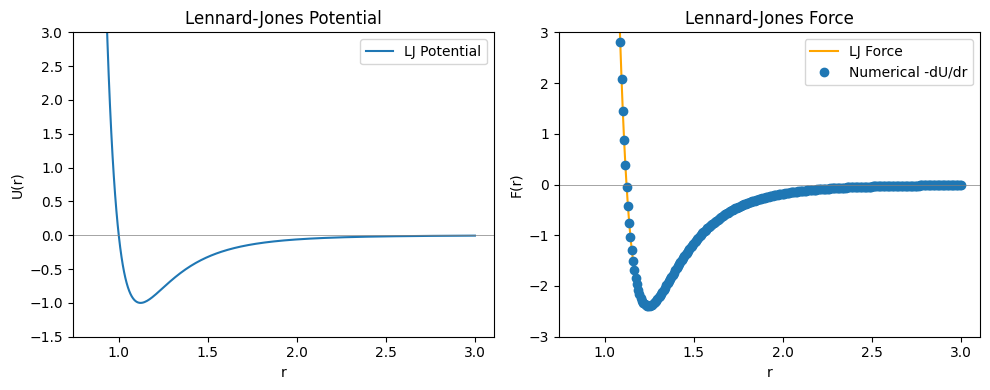

Max relative difference between analytic and numerical force: 1.9167889497850865e-11


In [4]:
# Visual inspection of the Lennard-Jones potential and force
import numpy as np
import matplotlib.pyplot as plt

# Range of r values (avoid r=0)
r = np.linspace(0.85, 3.0, 300)
epsilon = 1.0
sigma = 1.0
U = [compute_lj_potential(r_val, epsilon=epsilon, sigma=sigma) for r_val in r]
F = [compute_lj_force(np.array([r_val,0,0]), epsilon=epsilon, sigma=sigma)[0][0] for r_val in r]
F_num = [numerical_lj_force(np.array([r_val,0,0]), epsilon=epsilon, sigma=sigma)[0] for r_val in r]

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(r, U, label='LJ Potential')
plt.axhline(0, color='gray', lw=0.5)
plt.xlabel('r')
plt.ylabel('U(r)')
plt.ylim(-1.5*epsilon, 3.0*epsilon)
plt.title('Lennard-Jones Potential')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(r, F, label='LJ Force', color='orange')
plt.plot(r, F_num, 'o', label='Numerical -dU/dr')
plt.axhline(0, color='gray', lw=0.5)
plt.xlabel('r')
plt.ylabel('F(r)')
plt.ylim(-3.0*epsilon/sigma, 3.0*epsilon/sigma)
plt.title('Lennard-Jones Force')
plt.legend()

plt.tight_layout()
plt.show()

# test for randomly oriented vectors
r_vecs = np.random.normal(size=(10, 3), scale=3.0)  # 10 random displacement vectors
F_vecs = np.array([compute_lj_force(r_vec, epsilon=epsilon, sigma=sigma)[0] for r_vec in r_vecs])
F_num_vecs = np.array([numerical_lj_force(r_vec, epsilon=epsilon, sigma=sigma) for r_vec in r_vecs])
# Print max difference for verification
print('Max relative difference between analytic and numerical force:', np.max(np.abs(F_vecs - F_num_vecs)))

## 4. Initialization of a Particle System

Let's consider a system of $N$ particles in a simulation box.

We will initialize the particles on a **simple cubic lattice** to avoid overlapping positions (which would cause infinite forces). Then, we assign them random velocities drawn from a normal distribution, which will determine the initial kinetic energy (temperature) of the system.

In the code block below, a basic loop structure is implemented. **Your task** is to specify the particle positions on the cubic lattice.


In [5]:
import numpy as np
from numba import njit, prange
import matplotlib.pyplot as plt

# Simulation Parameters
num_particles = 400  # Total number of particles
rho = 0.8            # Number density (particles per unit volume)
L = (num_particles / rho)**(1/3)  # Box length derived from N and rho

# Approach: Create a simple cubic lattice with sufficient grid points to 
# accommodate all particles, then select the first num_particles points

@njit
def initialize_positions(num_particles, L):
    """
    Initializes particle positions on a simple cubic lattice.
    
    This ensures particles start with reasonable separations and avoid
    the singularity of the LJ potential at r=0.
    
    Args:
        num_particles (int): Total number of particles to initialize
        L (float): Length of the cubic simulation box
        
    Returns:
        ndarray: Array of shape (num_particles, 3) containing initial positions
    """
    pos = np.empty((num_particles, 3))

    # Calculate number of lattice points per dimension
    num_1d = int(np.ceil(num_particles**(1/3)))  # Particles per side for cubic lattice
    
    # Calculate lattice spacing
    spacing = L / num_1d
    
    count = 0
    for i in range(num_1d):
        for j in range(num_1d):
            for k in range(num_1d):
                if count < num_particles:
                    # Solution: Place particle on cubic lattice
                    pos[count, 0] = (i + 0.5) * spacing
                    pos[count, 1] = (j + 0.5) * spacing
                    pos[count, 2] = (k + 0.5) * spacing
                    count += 1
                else:
                    break
            if count >= num_particles:
                break
        if count >= num_particles:
            break
            
    return pos

def initialize_velocities(num_particles, std_v=1.0):
    """
    Initializes particle velocities from a normal distribution.
    
    The standard deviation controls the initial kinetic energy (temperature).
    By the equipartition theorem, <(1/2)mv^2> = (3/2)k_B*T for each particle.
    
    Args:
        num_particles (int): Total number of particles to initialize
        std_v (float): Standard deviation of the velocity distribution
        
    Returns:
        ndarray: Array of shape (num_particles, 3) containing initial velocities
    """
    return np.random.normal(0, std_v, size=(num_particles, 3))


## 5. Force Computation

Now we implement the core computational kernel of MD: calculating forces between all pairs of particles.

The total force on particle $i$ is the sum of pairwise forces from all other particles:
$$\mathbf{F}_i = \sum_{j \neq i} \mathbf{F}_{ij}$$

We implement this using a double loop over all pairs. By Newton's third law, $\mathbf{F}_{ij} = -\mathbf{F}_{ji}$, so we only need to compute each pair once and update both particles.

**Your Task:** Complete the force accumulation by updating the forces on both particle $i$ and particle $j$ using the computed pairwise force.


In [6]:
@njit
def compute_forces(pos, L, epsilon=1.0, sigma=1.0, r_c=None):
    """
    Computes forces on each particle due to Lennard-Jones interactions and the total potential energy.
    
    Args:
        pos (ndarray): Array of shape (num_particles, 3) containing particle positions
        L (float): Box length
        epsilon (float): The depth of the potential well
        sigma (float): The length scale of the interaction
        r_c (float): Cutoff distance. Note: In the first pass of implementation,
                     you may ignore the cutoff distance and implement it later.
    Returns:
        forces (ndarray): Array of shape (num_particles, 3) containing the force on each particle
        u_pot (float): Total potential energy of the system
    """
    num_particles = pos.shape[0]
    forces = np.zeros_like(pos)  # Initialize forces to zero
    u_pot = 0.0  # Accumulator for potential energy
    
    # Double loop over all unique pairs (i, j) with i < j
    for i in range(num_particles):
        for j in range(i + 1, num_particles):
            r_vec = pos[i] - pos[j]  # Displacement vector from j to i
            f_vec, u_pair = compute_lj_force(r_vec, epsilon, sigma)  # Compute force and potential for this pair
            # Task: Compute total forces on particles i and j due to their interaction
            forces[i] += f_vec
            forces[j] -= f_vec
            u_pot += u_pair
    return forces, u_pot

## 6. Velocity-Verlet Algorithm

The Velocity-Verlet algorithm is a time-reversible and symplectic integration scheme that conserves energy well for MD simulations. It advances the system by one timestep $\Delta t$ through the following sequence:

1. **Update velocities by half-step:** $\mathbf{v}^{n+1/2} = \mathbf{v}^n + \frac{\mathbf{F}^n}{2m}\Delta t$
2. **Update positions:** $\mathbf{r}^{n+1} = \mathbf{r}^n + \mathbf{v}^{n+1/2}\Delta t$
3. **Recompute forces:** $\mathbf{F}^{n+1}$ and $U_{\mathrm{pot}}^{n+1}$ at the new positions
4. **Update velocities by second half-step:** $\mathbf{v}^{n+1} = \mathbf{v}^{n+1/2} + \frac{\mathbf{F}^{n+1}}{2m}\Delta t$

**Your Task:** Complete the implementation of steps 2–4 in the function below.


In [7]:
def integrate(pos, vel, forces, L, dt=0.01, m=1.0, epsilon=1.0, sigma=1.0, r_c=None, pbc=False):
    """
    Performs one timestep of Velocity-Verlet integration with PBC.
    
    Args:
        pos (ndarray): Particle positions, shape (N, 3)
        vel (ndarray): Particle velocities, shape (N, 3)
        forces (ndarray): Forces on particles at current positions, shape (N, 3)
        L (float): Box length
        dt (float): Timestep size
        m (float): Particle mass (default: 1.0 in reduced units)
        epsilon (float): Depth of the potential well
        sigma (float): Finite distance at which the inter-particle potential is zero
        r_c (float): Cutoff distance. Note: In the first pass of implementation,
                     you may ignore the cutoff distance and implement it later.
        
    Returns:
        pos (ndarray): Updated positions
        vel (ndarray): Updated velocities
        forces (ndarray): Updated forces at new positions
        u_pot (float): Potential energy at new positions
        u_kin (float): Kinetic energy at new velocities
    """
    u_pot = 0.0  # Placeholder for potential energy at new positions

    # Step 1: Update velocities by half-step using current forces
    vel += 0.5 * forces / m * dt
    
    # Task: Implement the remaining steps of the Velocity-Verlet algorithm

    # Step 2: Update positions using updated velocities
    pos += vel * dt
    # Step 3: Recompute forces at new positions
    if pbc:
        pos = fold_in_box(pos, L)  # Apply periodic boundary conditions to positions
        forces, u_pot = compute_forces_periodic(pos, L, epsilon, sigma, r_c)  # Compute new forces and potential energy at updated positions
    else:
        forces, u_pot = compute_forces(pos, L, epsilon, sigma, r_c)  # Compute new forces and potential energy at updated positions
    # Step 4: Update velocities by another half-step using new forces
    vel += 0.5 * forces / m * dt  # Update velocities by another half-step using new forces
    
    # Calculate kinetic energy: K = (1/2) * m * sum(v^2)
    u_kin = 0.5 * m * np.sum(vel**2)
    
    return pos, vel, forces, u_pot, u_kin

## 7. Simulation Loop

Now we bring everything together in a simulation loop:
1. Initialize particle positions, velocities, and compute initial forces
2. Perform time integration for a specified number of timesteps
3. pbcally write particle positions to a trajectory file for visualization

The trajectory is saved in LAMMPS dump format, which can be visualized using tools like [OVITO](https://www.ovito.org/).

**Your Tasks:**
* Complete the `initialize()` function to set up the initial state
* Complete the `run()` function to perform the time integration loop


In [8]:
def write_dump(filename, step, pos, vel, L, mode='a'):
    """
    Writes particle positions and velocities to a LAMMPS-format dump file.
    
    Args:
        filename (str): Output file path
        step (int): Current timestep number
        pos (ndarray): Particle positions, shape (num_particles, 3)
        vel (ndarray): Particle velocities, shape (num_particles, 3)
        L (float): Box length
        mode (str): File open mode ('w' to overwrite, 'a' to append)
    """
    num_particles = pos.shape[0]
    with open(filename, mode) as f:
        f.write("ITEM: TIMESTEP\n")
        f.write(f"{step}\n")
        f.write("ITEM: NUMBER OF ATOMS\n")
        f.write(f"{num_particles}\n")
        f.write("ITEM: BOX BOUNDS pp pp pp\n")
        f.write(f"0.0 {L}\n0.0 {L}\n0.0 {L}\n")
        f.write("ITEM: ATOMS id type x y z vx vy vz\n")
        for i in range(num_particles):
            f.write(f"{i+1} 1 {pos[i,0]} {pos[i,1]} {pos[i,2]} {vel[i,0]} {vel[i,1]} {vel[i,2]}\n")

def initialize(num_particles, L, std_v=1.0, m=1.0, epsilon=1.0, sigma=1.0, r_c=None):
    """
    Initializes the system with PBC: positions, velocities, and initial forces.
    
    Args:
        num_particles (int): Total number of particles to initialize
        L (float): Length of the cubic simulation box
        std_v (float): Standard deviation of the velocity distribution
        m (float): Particle mass (default: 1.0 in reduced units)
        epsilon (float): The depth of the potential well
        sigma (float): The length scale of the interaction
        r_c (float): Cutoff distance. Note: In the first pass of implementation,
                     you may ignore the cutoff distance and implement it later.
    Returns:
        pos (ndarray): Initial positions
        vel (ndarray): Initial velocities
        forces (ndarray): Initial forces
        u_pot (float): Initial potential energy
        u_kin (float): Initial kinetic energy
    """
    pos = np.empty((num_particles, 3)) # Placeholder for positions
    vel = np.empty((num_particles, 3)) # Placeholder for velocities
    forces = np.empty((num_particles, 3)) # Placeholder for forces
    u_pot = 0.0  # Placeholder for potential energy
    u_kin = 0.0  # Placeholder for kinetic energy
    # Task: Initialize positions, velocities, and forces
    pos = initialize_positions(num_particles, L)
    vel = initialize_velocities(num_particles, std_v)
    forces, u_pot = compute_forces(pos, L, epsilon, sigma, r_c)
    u_kin = 0.5 * m * np.sum(vel**2)
    
    return pos, vel, forces, u_pot, u_kin

def run(pos, vel, forces, L, num_timesteps=1000, num_steps_between_dumps=100, dt=0.01, m=1.0, epsilon=1.0, sigma=1.0, r_c=None, filename="output.dump", pbc=False):
    """
    Runs the MD simulation with PBC for a specified number of timesteps.
    
    Args:
        pos (ndarray): Initial positions
        vel (ndarray): Initial velocities
        forces (ndarray): Initial forces
        L (float): Box length
        num_timesteps (int): Total number of timesteps to simulate
        num_steps_between_dumps (int): Frequency of trajectory output
        dt (float): Timestep size
        m (float): Particle mass
        epsilon (float): Depth of the potential well
        sigma (float): Finite distance at which the inter-particle potential is zero
        r_c (float): Cutoff distance. Note: In the first pass of implementation,
                     you may ignore the cutoff distance and implement it later.
        filename (str): Output filename
        pbc (bool): Whether to apply pbc boundary conditions (default: False)
        
    Returns:
        result (dict): Dictionary containing energies and final state
    """
    
    u_pot = 0.0  # Placeholder for potential energy
    u_kin = 0.0  # Placeholder for kinetic energy
    energies = []  # List to store (u_pot, u_kin) at each dump
    for step in range(num_timesteps):
        # Task: Integrate equations of motion to update positions and velocities
        pos, vel, forces, u_pot, u_kin = integrate(pos, vel, forces, L, dt, m, epsilon, sigma, r_c, pbc)

        # pbcally save trajectory and energy data
        if step % num_steps_between_dumps == 0:
            energies.append((u_pot, u_kin))
            write_dump(filename, step, pos, vel, L, 
                      mode='w' if step == 0 else 'a')
    
    # Return results as dictionary
    result = {
        'energies': energies,
        'pos': pos,
        'vel': vel,
        'forces': forces
    }
    return result

## 8. Intermediate Results and Visualization

Before implementing periodic boundary conditions, let's run a short simulation and examine the results.

**Tasks:**
* Initialize and run the simulation for a small number of timesteps
* Create plots of the potential energy, kinetic energy, and total energy as functions of time
* Download and install [OVITO](https://www.ovito.org/) (a free visualization tool for molecular simulations)
* Import the created `output.dump` trajectory file into OVITO
* Visualize the particle motion

**Expected Observations:**
* The total energy should remain approximately constant (energy conservation), varying much less than the individual kinetic and potential energy components
* Without pbc boundary conditions, you will likely observe that particles "fly off to infinity" — they leave the simulation box and do not return
* This demonstrates why we need boundary conditions for realistic simulations


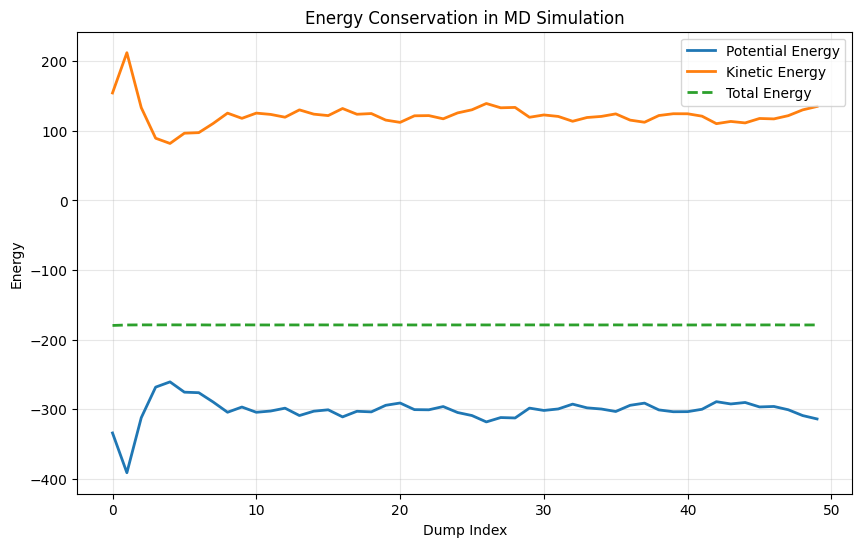

In [9]:
# Task: Specify the system parameters, initialize the system, and run the simulation
# Example:
num_particles = 108
rho = 0.8
L = (num_particles / rho)**(1/3)  # Box length derived from density

pos, vel, forces, u_pot, u_kin = initialize(num_particles, L)
result = run(pos, vel, forces, L, num_timesteps=1000, num_steps_between_dumps=20)

# Plot energy conservation
energies = np.array(result['energies'])
u_pot_array = energies[:, 0]
u_kin_array = energies[:, 1]
u_tot_array = u_pot_array + u_kin_array

plt.figure(figsize=(10, 6))
plt.plot(u_pot_array, label='Potential Energy', linewidth=2)
plt.plot(u_kin_array, label='Kinetic Energy', linewidth=2)
plt.plot(u_tot_array, label='Total Energy', linewidth=2, linestyle='--')
plt.xlabel('Dump Index')
plt.ylabel('Energy')
plt.title('Energy Conservation in MD Simulation')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


## 9. Periodic Boundary Conditions & Minimum Image Convention

To simulate a system at a specified density, we need boundaries. However, for small systems, interaction with physical walls would dominate the behavior. The solution is to use **Periodic Boundary Conditions (PBC)**.

### Conceptual Picture
In PBC, the simulation box is pbcally repeated in all directions, creating an infinite lattice of identical boxes. You only simulate one box, but:
* When a particle exits one side of the box, it re-enters from the opposite side
* Each particle interacts with particles in the central box and their pbc images

### Implementation

**1. Position Folding**

To keep particles within the box $[0, L)$, apply periodic wrapping. For the $x$-coordinate (and similarly for $y$ and $z$):
$$x_i := x_i - L \cdot \mathrm{floor}\left( \frac{x_i}{L} \right)$$

**2. Minimum Image Convention**

With infinite pbces, each particle has infinitely many neighbors. We introduce a **cutoff distance** $r_c$ beyond which interactions are neglected. For the Lennard-Jones potential, a common choice is $r_c = 2.5\sigma$.

For the minimum image convention to work correctly, we require:
$$L > 2 r_c$$

This ensures that particle $i$ can interact with at most one pbc image of particle $j$, namely, the closest one. To find the minimum image separation between particles $i$ and $j$, compute:
$$x_{ij} = x_i - x_j$$
$$x_{ij} := x_{ij} - L \cdot \mathrm{floor}\left( \frac{x_{ij}}{L} + 0.5 \right)$$

This formula shifts $x_{ij}$ to the range $[-L/2, L/2)$, giving the shortest distance considering periodic images.

### Your Tasks

1. **Create `min_image` function:** Implement a Numba-compiled function `min_image(r_vec, L)` that applies the minimum-image formula to a 3D displacement vector `r_vec`. After implementation, place this function **before** the definition of `compute_forces`.

2. **Modify `compute_forces`:** 
   - Add `L` and `r_c` as input parameters (suggest `r_c=None` as default)
   - For each pair, apply `min_image` to compute the minimum-image displacement $\mathbf{r}_{ij}$
   - Calculate $r_{\mathrm{sq}} = |\mathbf{r}_{ij}|^2$ (avoid unnecessary square roots)
   - If $r_{\mathrm{sq}} > r_c^2$, skip the force computation using `continue`

3. **Create `fold_in_box` function:** Implement a function that folds particle coordinates back into the box after each integration step. Apply the folding formula to all particles at once (use NumPy vectorization). Note: It's computationally cheaper to blindly apply folding to all particles rather than checking which ones are out of bounds first.

4. **Update `integrate` function:** Call `fold_in_box(pos, L)` after updating positions to ensure all particles remain within $[0, L)^3$.


In [10]:
import numpy as np
from numba import njit

@njit
def min_image(r_vec, L):
    """
    Applies the minimum image convention to a displacement vector.
    
    This function shifts the displacement vector to the range [-L/2, L/2) by
    accounting for periodic boundary conditions.
    
    Args:
        r_vec (ndarray): Displacement vector between two particles, shape (3,)
        L (float): Box length
        
    Returns:
        ndarray: Minimum image displacement vector, shape (3,)
    """
    # Solution: Apply minimum image formula
    # r_vec := r_vec - L * floor(r_vec / L + 0.5)
    r_vec -= L * np.floor(r_vec / L + 0.5)
    return r_vec

@njit
def fold_in_box(pos, L):
    """
    Wraps particle positions back into the periodic box [0, L).
    
    Args:
        pos (ndarray): Particle positions, shape (num_particles, 3)
        L (float): Box length
        
    Returns:
        ndarray: Wrapped positions, shape (num_particles, 3)
    """
    # Solution: Apply periodic wrapping using modulo operation
    pos -= L * np.floor(pos / L)
    return pos

@njit
def compute_forces_periodic(pos, L, epsilon=1.0, sigma=1.0, r_c=2.5):
    """
    Computes forces with Periodic Boundary Conditions and a cutoff distance.
    
    Args:
        pos (ndarray): Array of shape (num_particles, 3) containing particle positions
        L (float): Box length
        epsilon (float): The depth of the potential well
        sigma (float): The length scale of the interaction
        r_c (float): Cutoff distance. Note: In the first pass of implementation,
                     you may ignore the cutoff distance and implement it later.
    Returns:
        forces (ndarray): Array of shape (num_particles, 3) containing the force on each particle
        u_pot (float): Total potential energy of the system
    """
    num_particles = pos.shape[0]
    forces = np.zeros_like(pos)  # Initialize forces to zero
    u_pot = 0.0  # Accumulator for potential energy
    r_c_sq = r_c * r_c  # Square of cutoff distance for efficiency
    
    # Double loop over all unique pairs (i, j) with i < j
    for i in range(num_particles):
        for j in range(i + 1, num_particles):
            r_vec = pos[i] - pos[j]  # Displacement vector from j to i
            r_vec = min_image(r_vec, L)  # Apply minimum image convention
            r_sq = np.sum(r_vec**2)  # Squared distance for cutoff check
            if r_sq > r_c_sq:  # Only compute forces if within cutoff
                continue  # Skip this pair if beyond cutoff          
            f_vec, u_pair = compute_lj_force(r_vec, epsilon, sigma)  # Compute force and potential for this pair
            # Task: Compute total forces on particles i and j due to their interaction
            forces[i] += f_vec
            forces[j] -= f_vec
            u_pot += u_pair
    return forces, u_pot

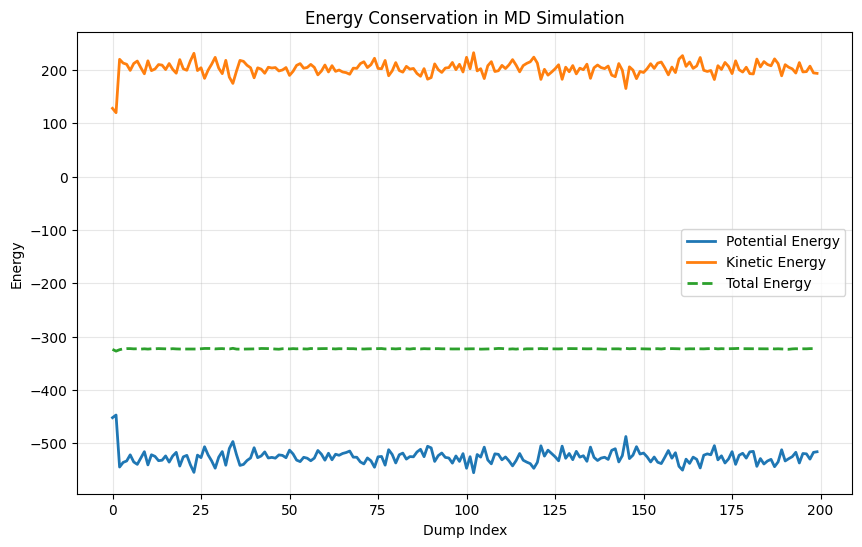

In [ ]:
# Task: Specify the system parameters, initialize the system, and run the simulation
# Example:
num_particles = 108
rho = 0.8
L = (num_particles / rho)**(1/3)  # Box length derived from density

pos, vel, forces, u_pot, u_kin = initialize(num_particles, L)
result = run(pos, vel, forces, L, num_timesteps=2000, num_steps_between_dumps=10, pbc=True, r_c=2.5, filename="output_periodic.dump")

# Plot energy conservation
energies = np.array(result['energies'])
u_pot_array = energies[:, 0]
u_kin_array = energies[:, 1]
u_tot_array = u_pot_array + u_kin_array

plt.figure(figsize=(10, 6))
plt.plot(u_pot_array, label='Potential Energy', linewidth=2)
plt.plot(u_kin_array, label='Kinetic Energy', linewidth=2)
plt.plot(u_tot_array, label='Total Energy', linewidth=2, linestyle='--')
plt.xlabel('Dump Index')
plt.ylabel('Energy')
plt.title('Energy Conservation in MD Simulation')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


### Ovito Python for post-processing

Ovito can be used for visualization and post-processing. For example, using the GUI the `modification` called `Coordination analysis` can be used to compute radial distribution functions of one frame in a simulation.
To get a high quality curve you would like to use `Time Averaging`. This is however not available in the non-payed basic version.
However, what is available is a Python interface. Below a implementation of a time-averaged radial distribution function using this Python interface is used.

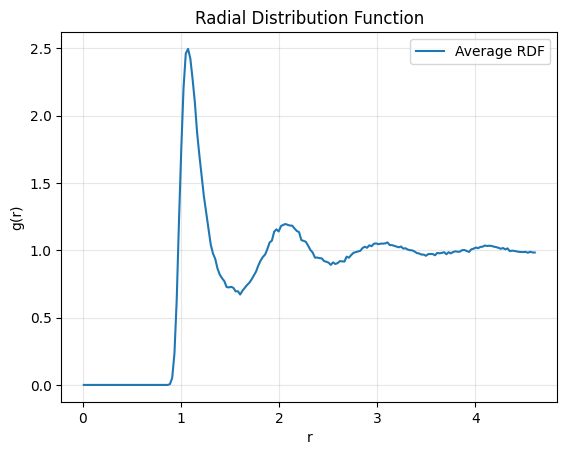

In [30]:
try:
    import ovito
except ImportError:
    install("ovito")

from ovito.io import import_file
from ovito.modifiers import CoordinationAnalysisModifier

# Load trajectory
def compute_rdf(filename, cutoff=10.0, number_of_bins=200, start_frame=0):
    pipeline = import_file(filename, multiple_frames=True)
    # Add RDF modifier
    rdf = CoordinationAnalysisModifier(
        cutoff=cutoff,       # set appropriate cutoff
        number_of_bins=number_of_bins
    )
    #rdf.compute_partial = False
    pipeline.modifiers.append(rdf)

    # Accumulate RDF over frames
    rdf_sum = None
    nframes = pipeline.source.num_frames

    for frame in range(start_frame, nframes):
        data = pipeline.compute(frame)
        table = data.tables['coordination-rdf']
        xy = table.xy()
        g_r = xy[:, 1]
        if rdf_sum is None:
            rdf_sum = np.zeros_like(g_r)
            r = xy[:, 0].copy()
        rdf_sum += g_r
        rdf_avg = rdf_sum / (nframes - start_frame)
    return r, rdf_avg

r, rdf_avg = compute_rdf("output_periodic.dump", cutoff=0.9*L, start_frame=25)
plt.plot(r, rdf_avg, label='Average RDF')
plt.xlabel('r')
plt.ylabel('g(r)')
plt.title('Radial Distribution Function')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 10. Production Runs and Analysis

With periodic boundary conditions implemented, you can now run realistic MD simulations and explore the behavior of the Lennard-Jones system.

**Tasks:**

1. **Parameter Studies:** Run simulations for a range of physical and numerical parameters:
   - **Physical parameters:** Density ($\rho$), magnitude of initial velocities (related to temperature)
   - **Numerical parameters:** Number of particles ($N$), timestep size ($\Delta t$), number of timesteps

2. **Energy Monitoring:** 
   - Plot potential, kinetic, and total energy vs. time
   - Monitor equilibration: initially, the system will adjust from the artificial lattice configuration toward a thermal equilibrium state
   - Verify energy conservation: total energy should fluctuate minimally around a constant value

3. **Trajectory Visualization:** 
   - Use OVITO to visualize particle trajectories
   - Apply post-processing and analysis tools in OVITO (e.g., compute radial distribution functions)

4. **Phase Behavior:** 
   - Can you identify parameters that lead to gas-like behavior (particles moving freely with few neighbors)?
   - Can you find liquid-like behavior (particles clustered but mobile)?
   - What about solid-like behavior (particles oscillating around fixed lattice positions)?

5. **Optional Challenge:** Implement the simpler Euler-forward time integration scheme and compare its accuracy and stability to Velocity-Verlet. You should observe that Velocity-Verlet maintains energy conservation much better, especially for larger timesteps.


Completed simulation and RDF computation for rho=0.1.
Completed simulation and RDF computation for rho=0.3.
Completed simulation and RDF computation for rho=0.5.
Completed simulation and RDF computation for rho=0.8.
Completed simulation and RDF computation for rho=1.0.


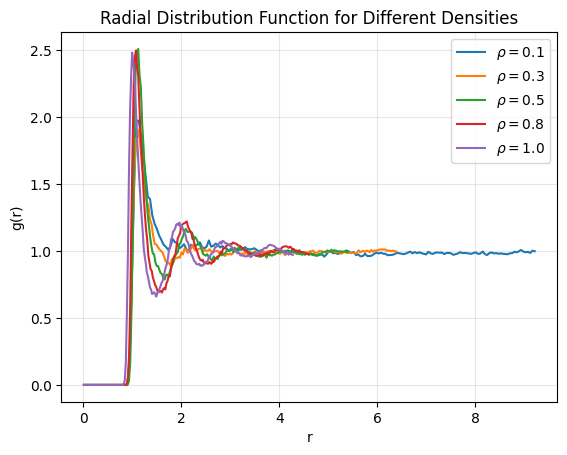

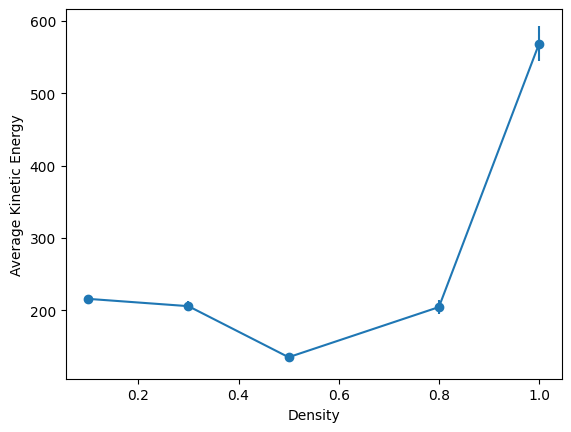

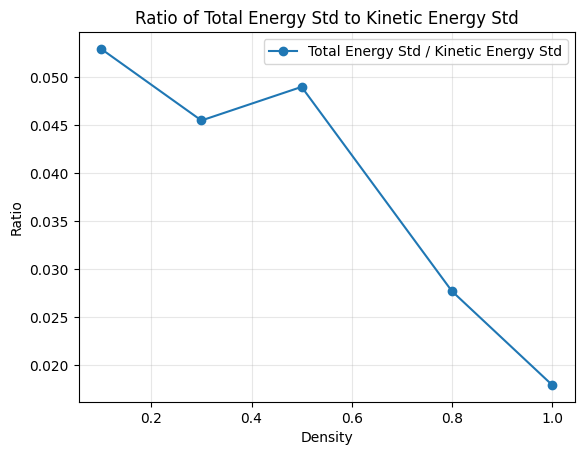

In [41]:
num_particles = 108
r_c = 2.5
dt = 0.005
number_densities = [0.1, 0.3, 0.5, 0.8, 1.0]
u_kin_avg = []
u_kin_std = []
u_tot_std = []

for i, rho in enumerate(number_densities):
    filename = f"output_periodic_rho_{rho}.dump"
    L = (num_particles / rho)**(1/3)  # Box length derived from density
    if L < 2.0*r_c:
        print(f"Warning: Box length L={L:.2f} is smaller than cutoff r_c={r_c} for rho={rho}.")
    pos, vel, forces, u_pot, u_kin = initialize(num_particles, L)
    result = run(pos, vel, forces, L, num_timesteps=500, num_steps_between_dumps=500, pbc=True, r_c=r_c, dt=dt, filename=filename) # Equilibration run
    result = run(pos, vel, forces, L, num_timesteps=2000, num_steps_between_dumps=10, pbc=True, r_c=r_c, dt=dt, filename=filename) # Production run
    energies = np.array(result['energies'])
    u_pot = energies[:, 0]
    u_kin = energies[:, 1]
    u_tot = u_pot + u_kin
    u_kin_avg.append(np.mean(u_kin))
    u_kin_std.append(np.std(u_kin))
    u_tot_std.append(np.std(u_tot))

    r, rdf_avg = compute_rdf(filename, cutoff=0.9*L)
    plt.plot(r, rdf_avg + i*0.0, label=rf'$\rho={rho}$')
    print(f"Completed simulation and RDF computation for rho={rho}.")
plt.xlabel('r')
plt.ylabel('g(r)')
plt.title('Radial Distribution Function for Different Densities')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

plt.errorbar(number_densities, u_kin_avg, yerr=u_kin_std, fmt='o-', label='Kinetic Energy')
plt.xlabel('Density')
plt.ylabel('Average Kinetic Energy')
plt.show()

plt.plot(number_densities, np.array(u_tot_std)/np.array(u_kin_std), 'o-', label='Total Energy Std / Kinetic Energy Std')
plt.xlabel('Density')
plt.ylabel('Ratio')
plt.title('Ratio of Total Energy Std to Kinetic Energy Std')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()